In [177]:
import random
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


The data used for this project is the NASA C-MAPSS Turbofan Engine Degradation Data Set https://ti.arc.nasa.gov/c/6/.  This data is model based simulated data from the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS).

The data set is a multivariate time series. Each entry (row) reflects an operational cycle of a specific engine identified by engine id and cycle time. There are multiple entries per engine to represent different reporting times. Other columns represents different features 3 operational settings and 21 sensors:

<pre>
    1)      engine id
    2)      time, in cycles
    3)      operational setting 1
    4)      operational setting 2
    5)      operational setting 3
    6)      sensor measurement  1
    7)      sensor measurement  2
    ...
    26)     sensor measurement  21
</pre>



The CMAPSS data is divided into training, test, and RUL data files. Each of these is further partitioned in 4 subsets that represents a different operational condition. The number of engines in varies in each file.

In [178]:
DATA_DIR = "./data/"

In [179]:
!ls {DATA_DIR}

CMAPSSDATA.zip                  test_FD003.txt
Damage Propagation Modeling.pdf test_FD004.txt
RUL_FD001.txt                   test_x.csv
RUL_FD002.txt                   test_y.csv
RUL_FD003.txt                   train.csv
RUL_FD004.txt                   train_FD001.txt
readme.txt                      train_FD002.txt
test_FD001.txt                  train_FD003.txt
test_FD002.txt                  train_FD004.txt


In [180]:
cols = ['id', 'cycle' ]

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
cols.extend(sensor_cols)

# The data already comes sorted, but to be on the safe we will 
# maintain an order based on engine and cycle and ascending cycle.
sort_cols = ['id','cycle']


Each training fine begins with an engine id starting at 1. To ensure uniqueness, a base will be added to each file using the following mapping. Also, there are two distince conditions that will be mapped.

In [181]:
fn_id_map = {
    "train_FD001": 1000,
    "train_FD002": 2000,
    "train_FD003": 3000,
    "train_FD004": 4000,
    "test_FD001":  5000,
    "test_FD002":  6000,
    "test_FD003":  7000,
    "test_FD004":  8000,    
}


# Filename is mapped to a condition. Map:
#       ONE (Sea Level) to 1
#       SIX to 2
#       unknown is left as 0
fn_condition_map = {
    "train_FD001": 1,
    "train_FD002": 2,
    "train_FD003": 1,
    "train_FD004": 2,
    "test_FD001":  1,
    "test_FD002":  2,
    "test_FD003":  1,
    "test_FD004":  2,    
}

The raw files have no headers, are space delimited, and contain some training space. The following function will import the data, add a column name, update the id to be unique, add a 'condition' column to represent the data set, and maintain the sort order. 


In [182]:
def load_data(paths, col_names, sort_cols):
    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[26, 27]], axis=1, inplace=True)
        instance_df.columns = col_names
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        
        df = pd.concat((df, instance_df), sort=False) 

    df['condition'] = df['filename'].apply( lambda f: fn_condition_map[f])
    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f])
    df.drop(['filename'], axis=1, inplace=True)
    df = df.sort_values(sort_cols)
    return df

In [183]:
path = os.path.join(DATA_DIR, "train_FD*.txt")
all_files = glob.glob(path)

train_df = load_data(all_files, cols, sort_cols)
train_df.head(5)

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0  1001      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1  1001      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2  1001      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3  1001      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4  1001      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   

        s4     s5    ...          s13      s14     s15   s16  s17   s18  \
0  1400.60  14.62    ...      2388.02  8138.62  8.4195  0.03  392  2388   
1  1403.14  14.62    ...      2388.07  8131.49  8.4318  0.03  392  2388   
2  1404.20  14.62    ...      2388.03  8133.23  8.4178  0.03  390  2388   
3  1401.87  14.62    ...      2388.08  8133.83  8.3682  0.03  392  2388   
4  1406.22  14.62    ...      2388.04  8133.80  8.4294  0.03  393  2388   

     s19    s20      s21  condition  
0  100.0  39.06  23.4190          1  
1  100.0  39.00  23.4236          1  
2  100.0  38.95  23.3442          1  
3  100.0  38.88  23.3739          1  
4  100.0  38.90  23.4044          1  

[5 rows x 27 columns]

In a training data set file the complete series per engine from beginning to end of life is given. An engnine's last cycle entry signifies when the engine is declared unhealthy. For example, the first engine has 192 distinct time series events where the cycle will range from 1 to 192 inclusively. Thus the remaining useful life (RUL) of this engine will begin at 192 and go down to 1. During the upcoming data preparation I add an label column called ‘RUL’ that will serve as the ground truth label we will train with. 


In [220]:

[ (k,v) if k.startswith('train') else None for k, v in fn_id_map.items()]

[('train_FD001', 1000),
 ('train_FD002', 2000),
 ('train_FD003', 3000),
 ('train_FD004', 4000),
 None,
 None,
 None,
 None]

In [227]:
# Find the number of cycles per engine
train_df_cycle_count = train_df.groupby(['id']).agg(['count']).reset_index()[['id', 'cycle']]

# Count the number of engines in this data set
num_engines = train_df_cycle_count.shape[0]
print("Number of training engines: ", num_engines)

data_summary = train_df_cycle_count['cycle'].describe().rename(columns={"count": "Total"})

for filename, base_index in fn_id_map.items():
    fd = train_df_cycle_count[ (train_df_cycle_count['id'] >= base_index) & (train_df_cycle_count['id'] < (base_index+1000)) ]['cycle']
    if fd.shape[0] > 0:
        fd = fd.describe().rename(columns={"count": filename})
        data_summary = data_summary.merge(fd,left_index=True,right_index=True,how='left')
    
data_summary

Number of training engines:  709


Total  train_FD001  train_FD002  train_FD003  train_FD004
count  709.000000   100.000000   260.000000    100.00000    249.00000
mean   226.176305   206.310000   206.765385    247.20000    245.97992
std     66.434783    46.342749    46.782198     86.48384     73.11080
min    128.000000   128.000000   128.000000    145.00000    128.00000
25%    181.000000   177.000000   174.000000    189.75000    190.00000
50%    207.000000   199.000000   199.000000    220.50000    234.00000
75%    259.000000   229.250000   230.250000    279.75000    290.00000
max    543.000000   362.000000   378.000000    525.00000    543.00000

Investigating the training data, the mean cycle length is 206.31 cycles. The earliest failure is at 128 cycles, while the maximum is at 362 which seems to be an outlier. The plot below shows the clustering of cycle lengths around the mean.

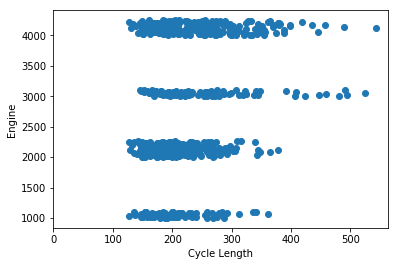

In [239]:
plt.scatter( train_df_cycle_count['cycle'], train_df_cycle_count['id'])
plt.xlim(0)
plt.xlabel("Cycle Length")
plt.ylabel("Engine")

plt.show()

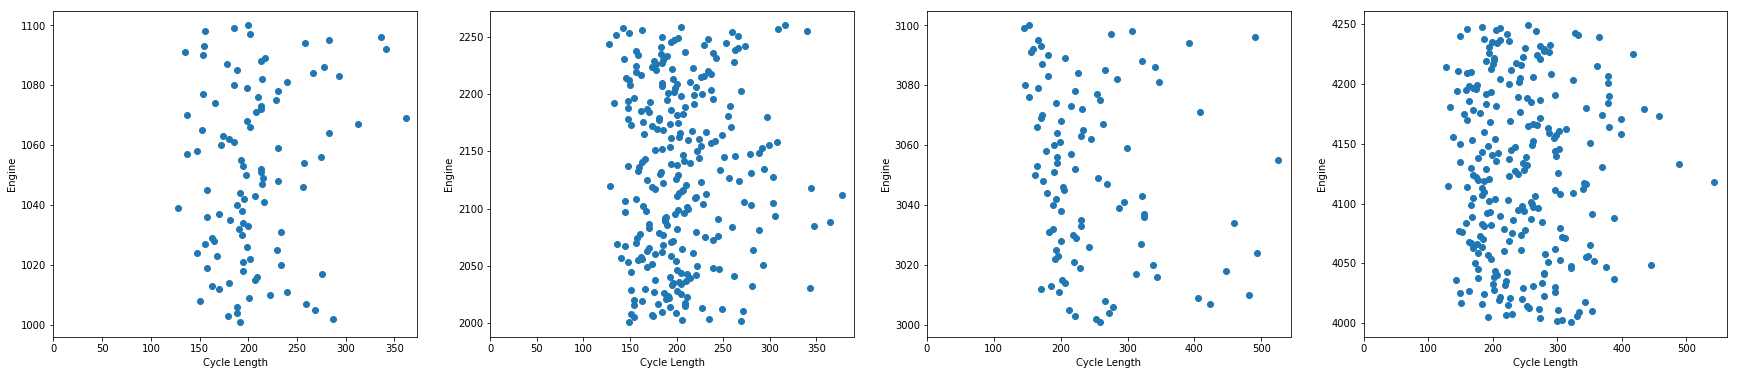

In [238]:
plt.figure(figsize=(30,6))
for i, fn_id in enumerate(fn_id_map.items()):

    fd = train_df_cycle_count[ (train_df_cycle_count['id'] >= fn_id[1]) & (train_df_cycle_count['id'] < (fn_id[1]+1000)) ]

    if fd.shape[0] > 0:

        ax = plt.subplot(1, 4, i+1)

        plt.scatter( fd['cycle'], fd['id'])
        plt.xlim(0)
        plt.xlabel("Cycle Length")
        plt.ylabel("Engine")

plt.show()

Check out the correlation between fields using pandas and display using seaborn. The combined view shows the negative correlation with operational settings 2, 3 and condition. 

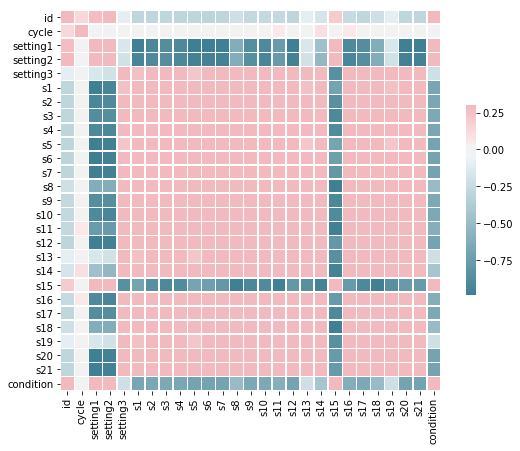

In [240]:
corr = train_df.corr()
f, ax = plt.subplots(figsize=(9, 7))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

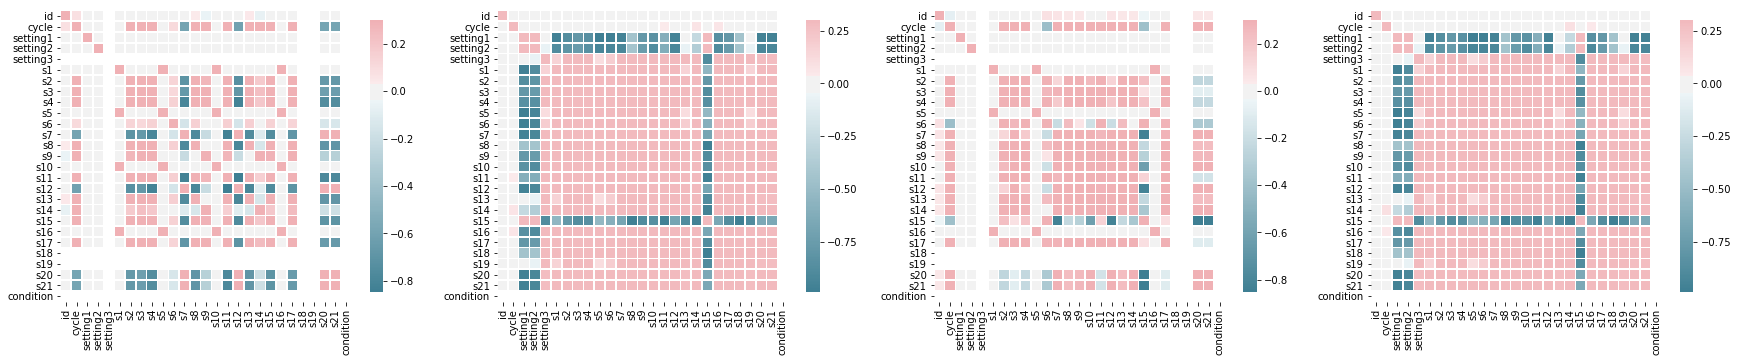

In [246]:
plt.figure(figsize=(30,10))
for i, fn_id in enumerate(fn_id_map.items()):

    fd = train_df[ (train_df['id'] >= fn_id[1]) & (train_df['id'] < (fn_id[1]+1000)) ]

    if fd.shape[0] > 0:

        ax = plt.subplot(1, 4, i+1)

        corr = fd.corr()
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


For data with condition ONE type data sets, Cycle has a relatively high corelation with the various sensors. 
Settings have low correlation.
Some sensors such as S20 and s21 standout has having negative correlation with other sensors. 

For data from condition SIX data sets, operational settings 2 and 3 have high negative correlation while all sensors seem to have a part to play.


Below we will plot some of the feature columes. One thing to note, as stated in the CMAPSS readme "The data is contaminated with sensor noise."

In [161]:
from scipy.interpolate import make_interp_spline, BSpline

# Function for plotting multiple feature columns together. 
def display_data(df, engine_id, col_names, rul_df=None, bspline=True):
    
    engine_data = df[df['id'] == engine_id]
    samples = engine_data.shape[0]
    x = np.arange(samples)
    
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = n // nrows
    
    fig = plt.figure(figsize=(20, n))
    
    print("Engine: {}, Samples: {}, Features: {}".format( engine_id, samples, n))
    
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        y = engine_data[m].values
        ax.plot(x, y)
    
        if bspline:
            x_smooth = np.linspace(x.min(),x.max(), 3)
            spl = make_interp_spline(x, y, k=7)
            y_smooth = spl(x_smooth)
            ax.plot(x_smooth, y_smooth)
        
        if rul_df is not None:
            rul_value = rul_df[ rul_df['id'] == engine_id]['RUL_actual'].item()
            cycles = rul_df[ rul_df['id'] == engine_id]['cycles'].item()

            ax.axvline(x=(rul_value+cycles), color='r')
    
    plt.tight_layout()
    plt.show()  

Engine 1001

Engine: 1001, Samples: 192, Features: 3


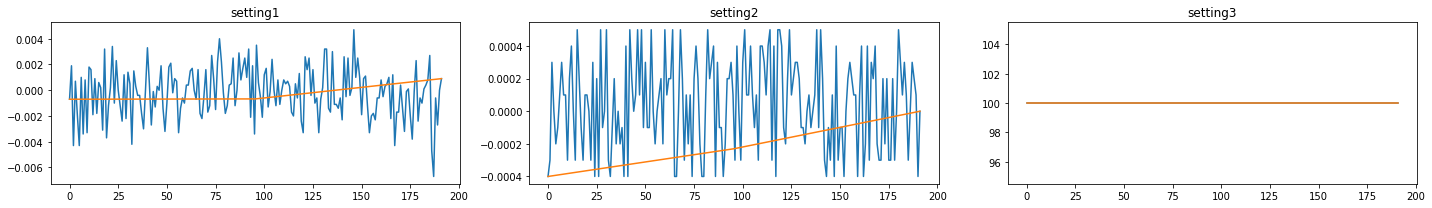

In [247]:
display_data( train_df, 1001, setting_cols)

Engine: 1001, Samples: 192, Features: 21


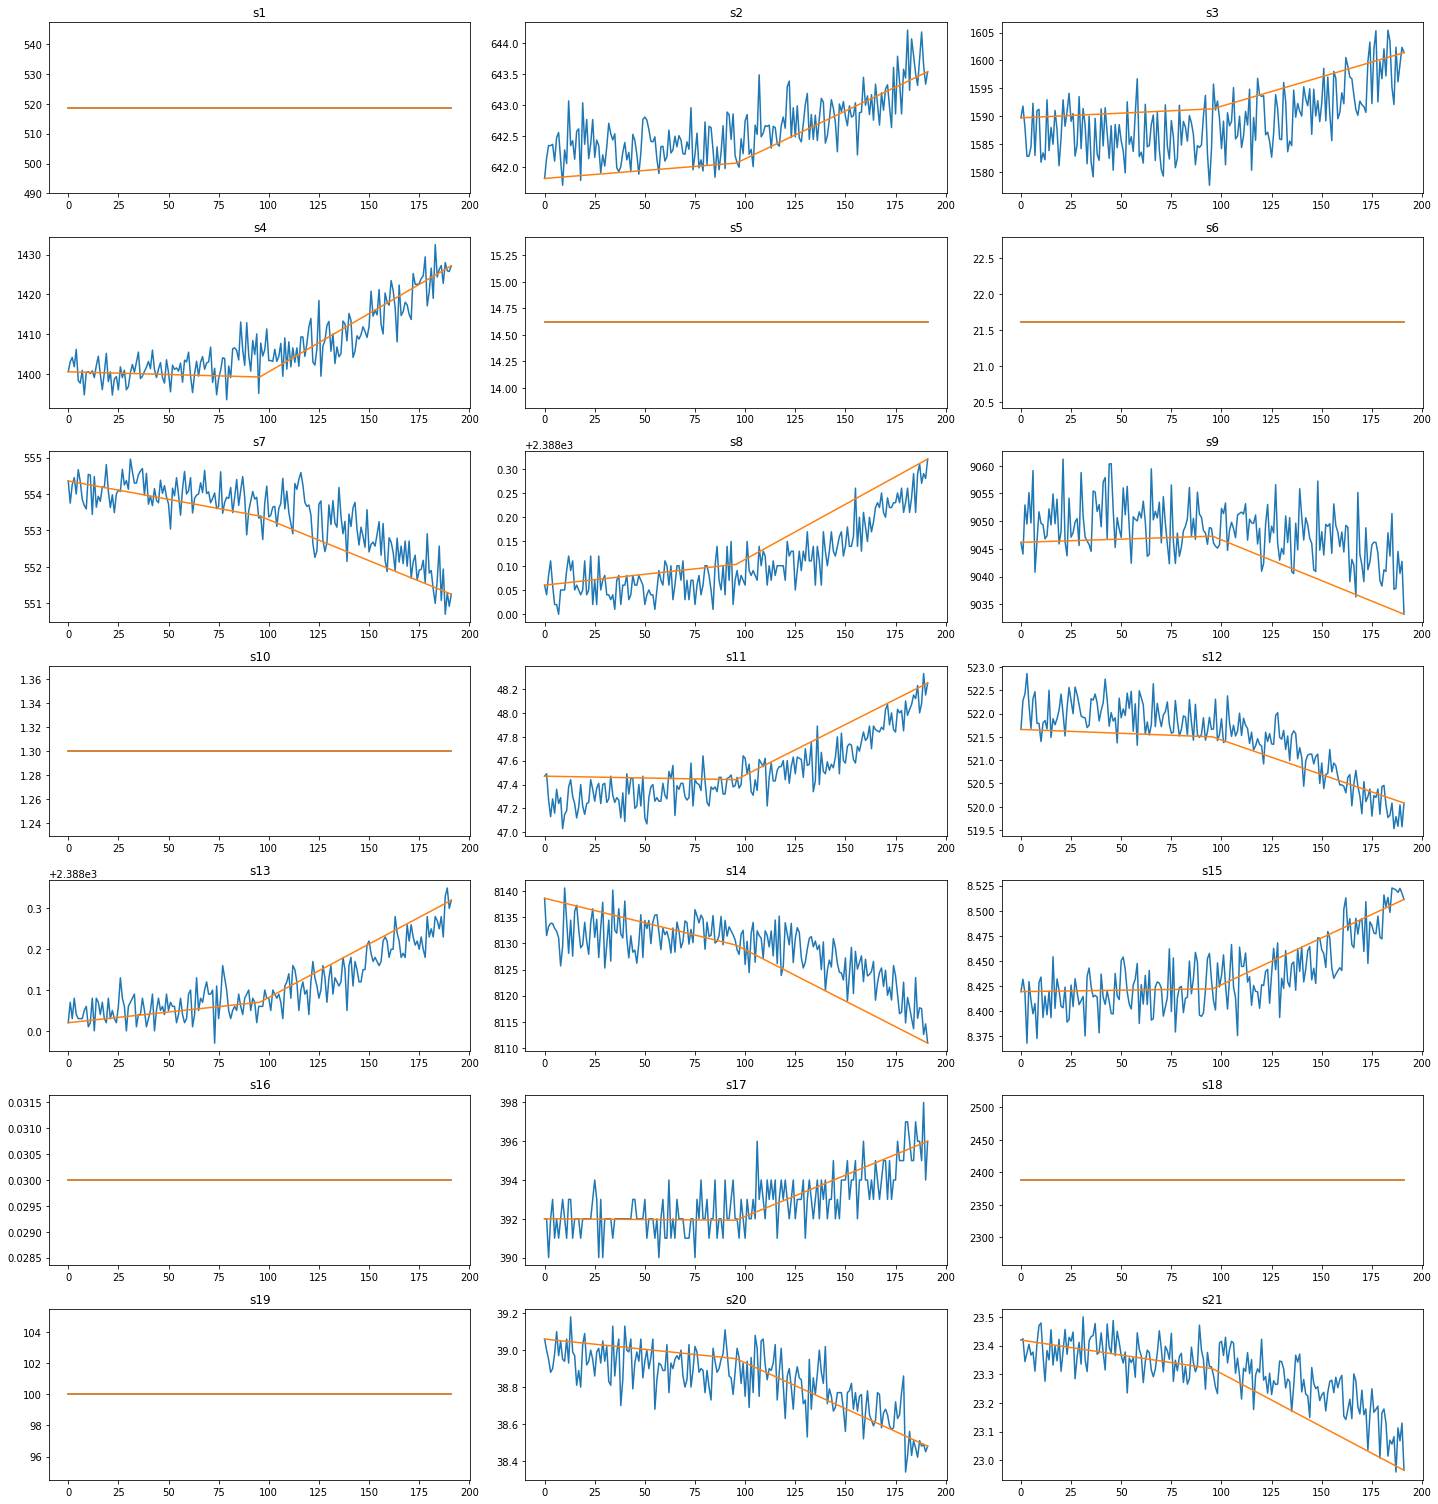

In [248]:
display_data( train_df, 1001, sensor_cols)

This is consistent with equipment failure. It is not linear, rather it reaches an inflection point or kink where degradation increases at a faster rate.


Sensor reading from condition SIX type engines show an entirly different behavior. The kink is missing from the data set.

Engine 2001

Engine: 2001, Samples: 149, Features: 3


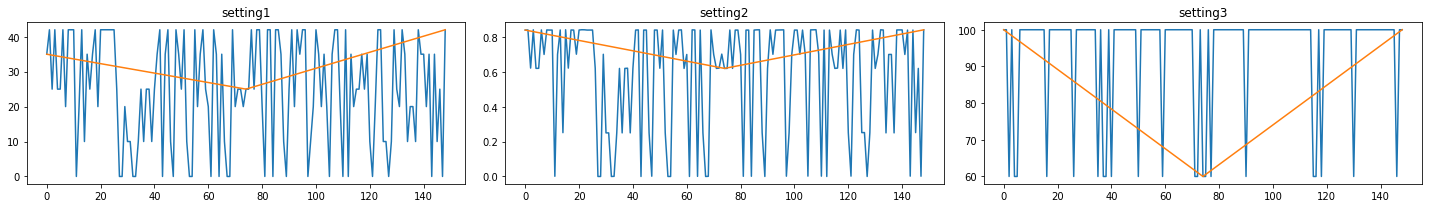

In [249]:
display_data( train_df, 2001, setting_cols)

Engine: 2001, Samples: 149, Features: 21


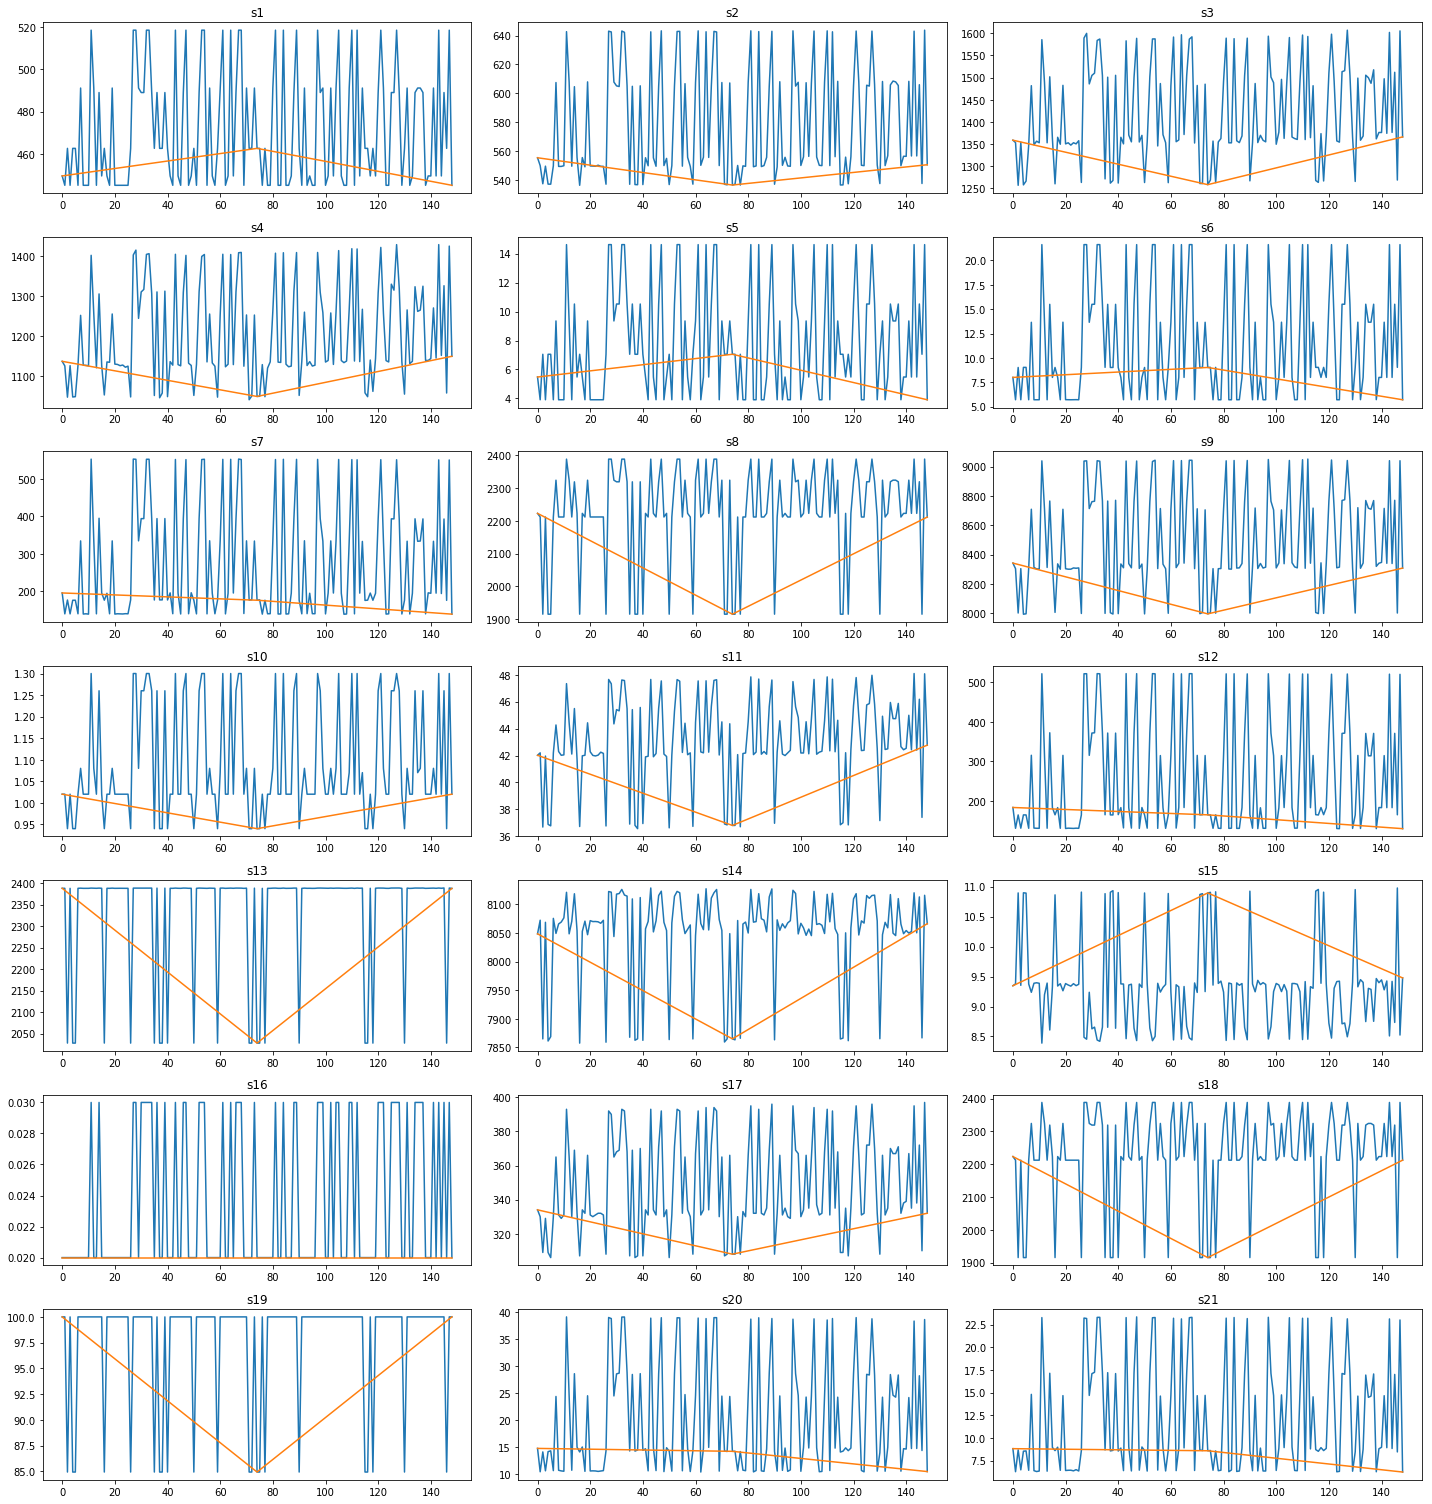

In [250]:
display_data( train_df, 2001, sensor_cols)

The next set of plots shows a random sampling of 10 engines. This depicts some general trends. 
* Different engines are failing at different times
* Rate of sensor change varies but is distinct and more severe as end of life is approached
* Some sensor data has no correlation
* Noise is evident in the sensor data


In [251]:
def display_multiple(df, engines, col_names):
    
    engine_data = []
    
    for i in engines:
        engine_id = i + 1 
        engine = train_df[train_df['id'] == engine_id]
        engine_data.append(engine)
        
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = n // nrows
    
    fig = plt.figure(figsize=(20, n))
        
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        for i in range(len(engine_data)):
            e = engine_data[i]
            x = np.arange(e.shape[0])
            y = e[m].values
            ax.plot(x, y)
    
    plt.tight_layout()
    plt.show()  

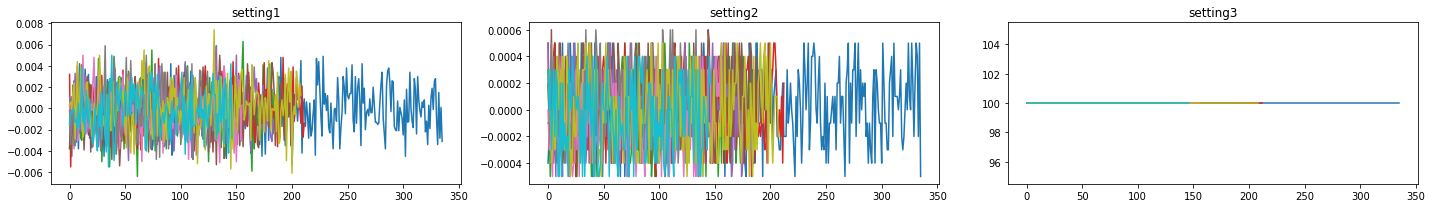

In [269]:
# Compare 10 condition ONE random engines

fd = train_df_cycle_count[ (train_df_cycle_count['id'] >= 1000) & (train_df_cycle_count['id'] < 2000) ]
engine_idx = random.sample(range(1,fd.shape[0]), 10)

engine_ids = fd.loc[engine_idx]['id']

display_multiple( train_df, engine_ids, setting_cols)


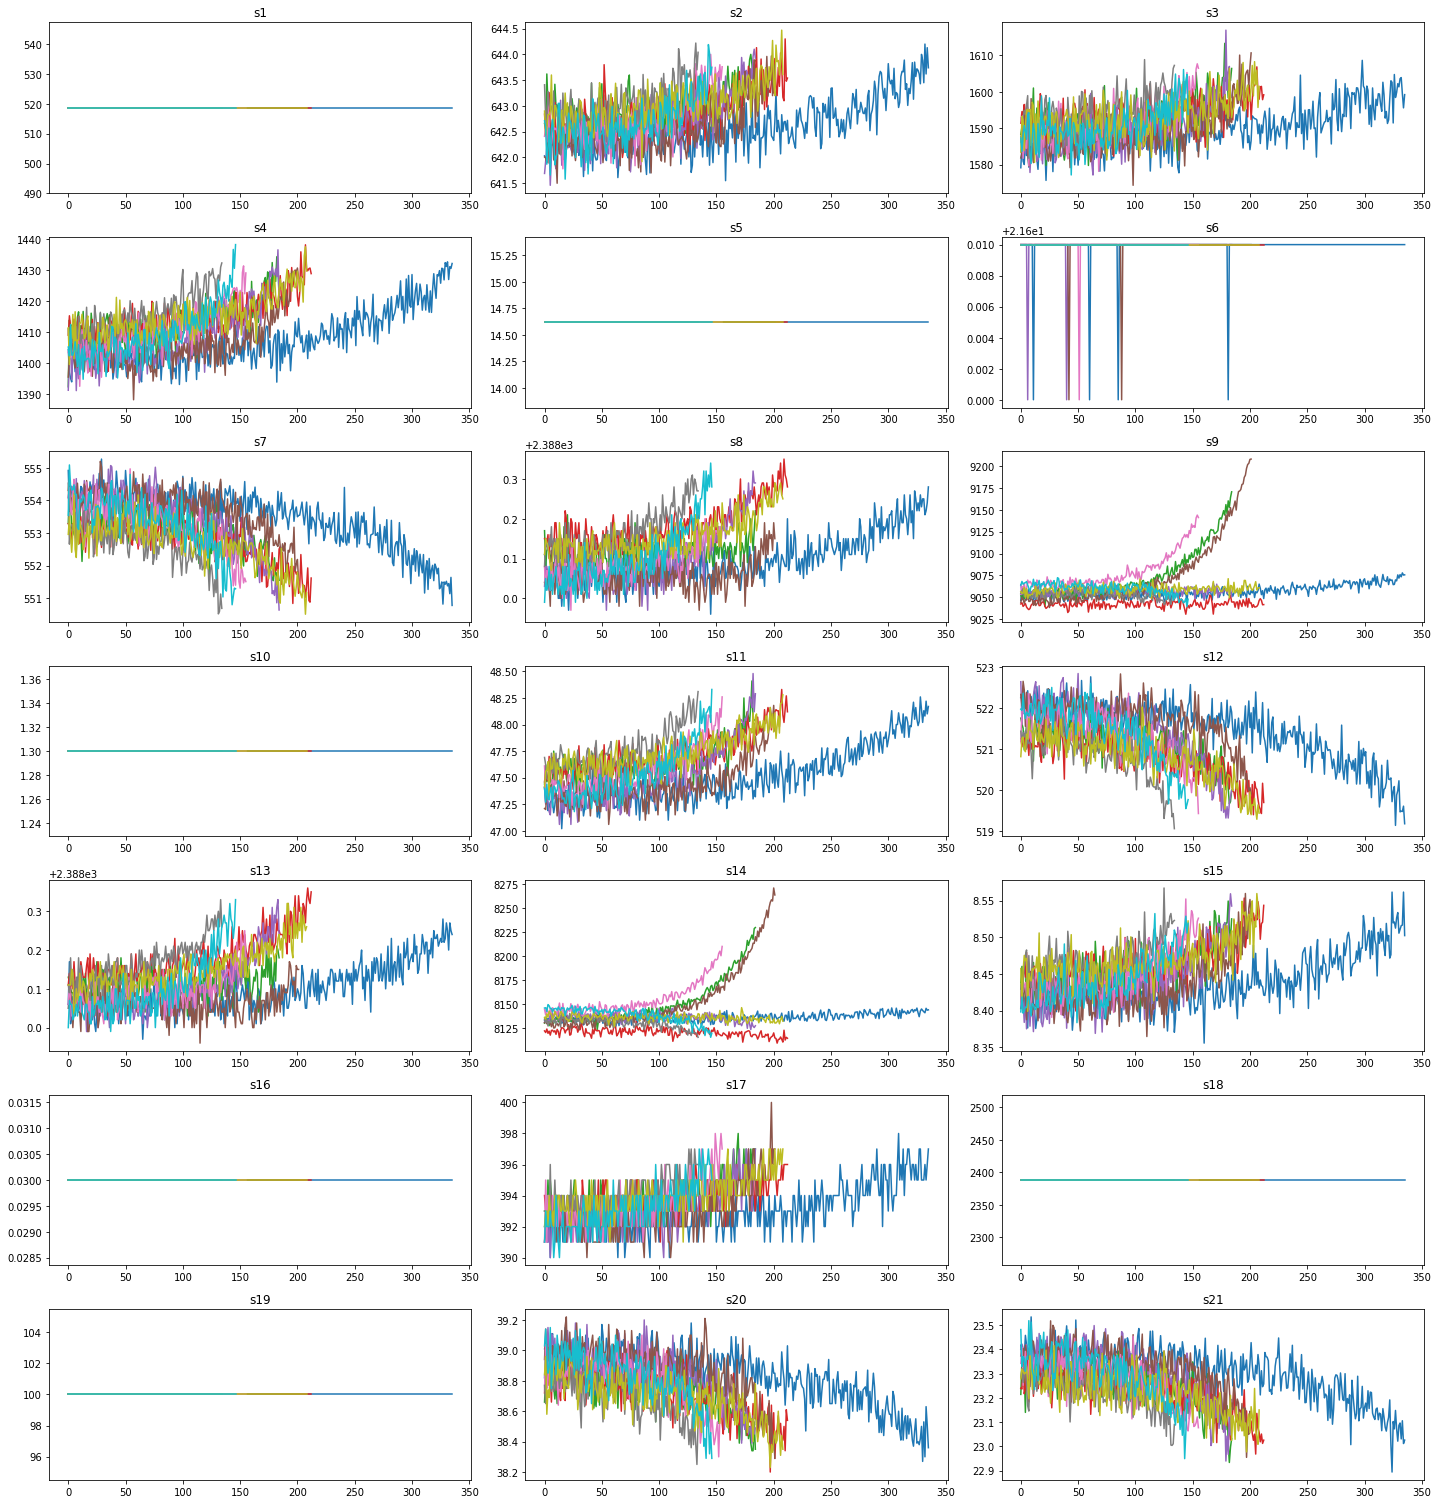

In [270]:
# Sensors
display_multiple( train_df, engine_ids, sensor_cols)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


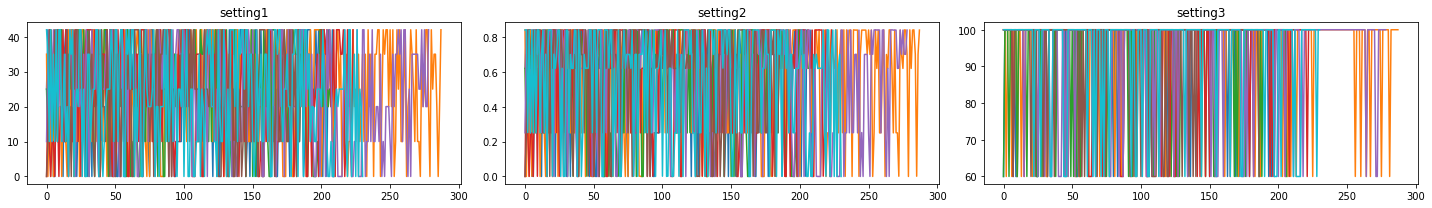

In [271]:
# Compare 10 condition SIX random engines

fd = train_df_cycle_count[ (train_df_cycle_count['id'] >= 2000) & (train_df_cycle_count['id'] < 3000) ]
engine_idx = random.sample(range(1,fd.shape[0]), 10)

engine_ids = fd.loc[engine_idx]['id']

display_multiple( train_df, engine_ids, setting_cols)

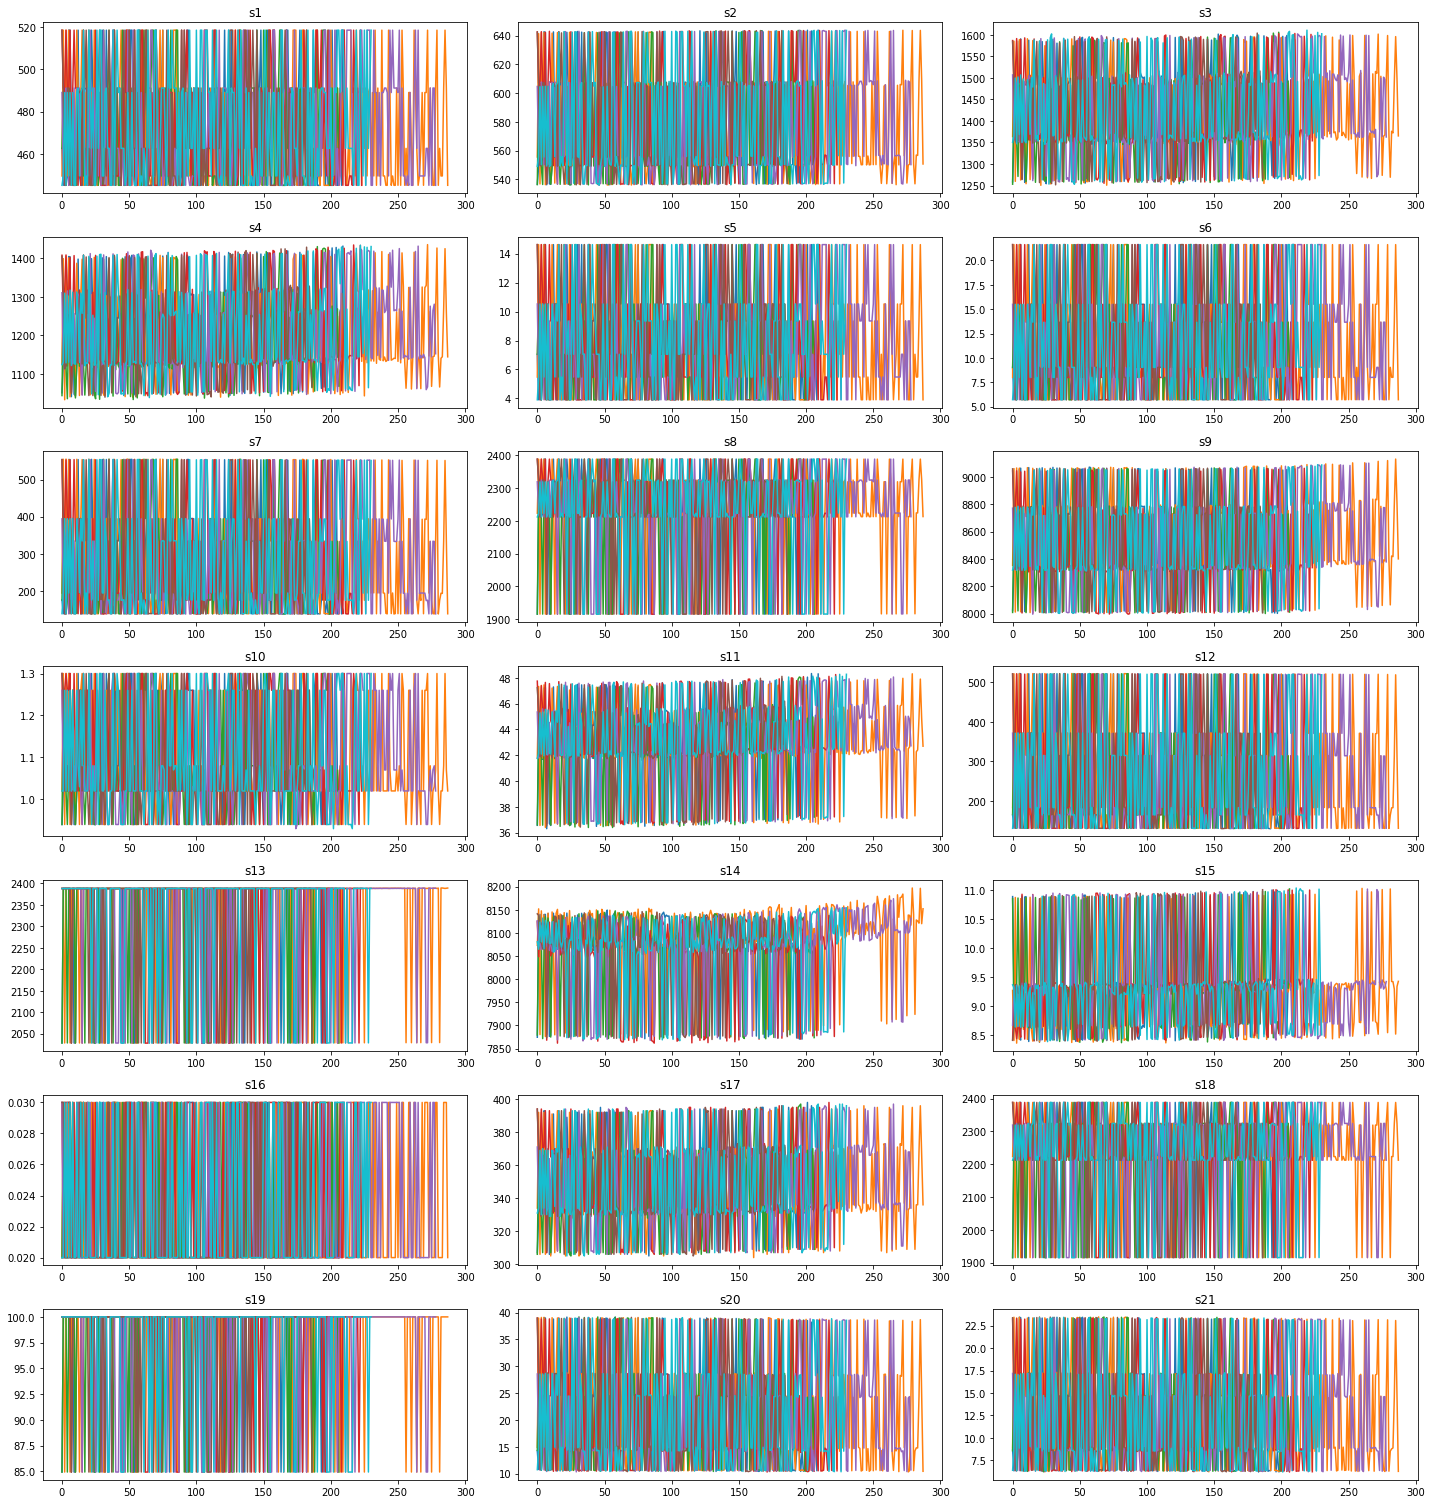

In [272]:
# Sensors
display_multiple( train_df, engine_ids, sensor_cols)


### Validation and Test data

In the original challenge the goal was to predict the RUL of engines in the test data as of the last entry. Since the actual RUL is present, I'll be using  some of the test files for both validatation (FD001) and testing (FD002).

The test data is unlike the training data. An engine’s status is terminated prior to actual engine failure. The last entry has an RUL identified in the RUL test files. If the time series for an engine in the test data ends at 41, the model’s goal is to identify the RUL at that point.  



In [58]:
# Read in the val X data
val_df = load_data([DATA_DIR+'test_FD001.txt'], cols, sort_cols)


In [59]:
# Read in the val Y data.
val_rul_df = pd.read_csv(DATA_DIR+'RUL_FD001.txt', sep=" ", header=None)
# Remove the null column
val_rul_df.drop(val_rul_df.columns[[1]], axis=1, inplace=True)
val_rul_df.columns = ['RUL_actual']

In [60]:
# If index is not reset there will be int/str type issues when attempting the merge. 
val_cycle_count_df = val_df.groupby('id').count().reset_index()[['id','cycle']].rename(index=str, columns={"cycle":"cycles"}).reset_index(drop=True)

# For each engine, join cycle count and RUL actual
assert val_cycle_count_df.shape[0] == val_rul_df.shape[0]
df = val_cycle_count_df.merge(val_rul_df, left_index=True, right_index=True, how='left')
df['RUL_actual'] = df['cycles'] + df['RUL_actual']
val_rul_df = df

# Join the two data frames
val_df = val_df.merge( df, on='id', how='left')

# Use the cycle to decrement the RUL until the ground truth is reached.
val_df['RUL'] = val_df['RUL_actual'] - val_df['cycle']
val_df.drop('RUL_actual',  axis=1, inplace=True)
val_df.drop('cycles',  axis=1, inplace=True)


val_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0  5001      1    0.0023    0.0003     100.0  518.67  643.02  1585.29   
1  5001      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45   
2  5001      3    0.0003    0.0001     100.0  518.67  642.46  1586.94   
3  5001      4    0.0042    0.0000     100.0  518.67  642.44  1584.12   
4  5001      5    0.0014    0.0000     100.0  518.67  642.51  1587.19   

        s4     s5 ...       s14     s15   s16  s17   s18    s19    s20  \
0  1398.21  14.62 ...   8125.55  8.4052  0.03  392  2388  100.0  38.86   
1  1395.42  14.62 ...   8139.62  8.3803  0.03  393  2388  100.0  39.02   
2  1401.34  14.62 ...   8130.10  8.4441  0.03  393  2388  100.0  39.08   
3  1406.42  14.62 ...   8132.90  8.3917  0.03  391  2388  100.0  39.00   
4  1401.92  14.62 ...   8129.54  8.4031  0.03  390  2388  100.0  38.99   

       s21  condition  RUL  
0  23.3735          1  142  
1  23.3916          1  141  
2  23.4166          1  140  
3  23.3737          1  139  
4  23.4130          1  138  

[5 rows x 28 columns]

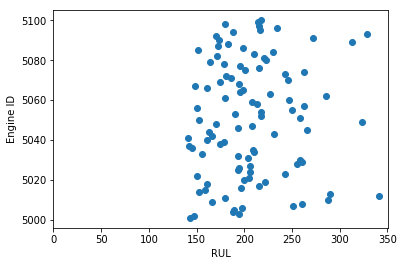

In [61]:
plt.scatter(val_rul_df['RUL_actual'], val_rul_df['id'])

plt.xlim(0)
plt.xlabel("RUL")
plt.ylabel("Engine ID")
plt.show()

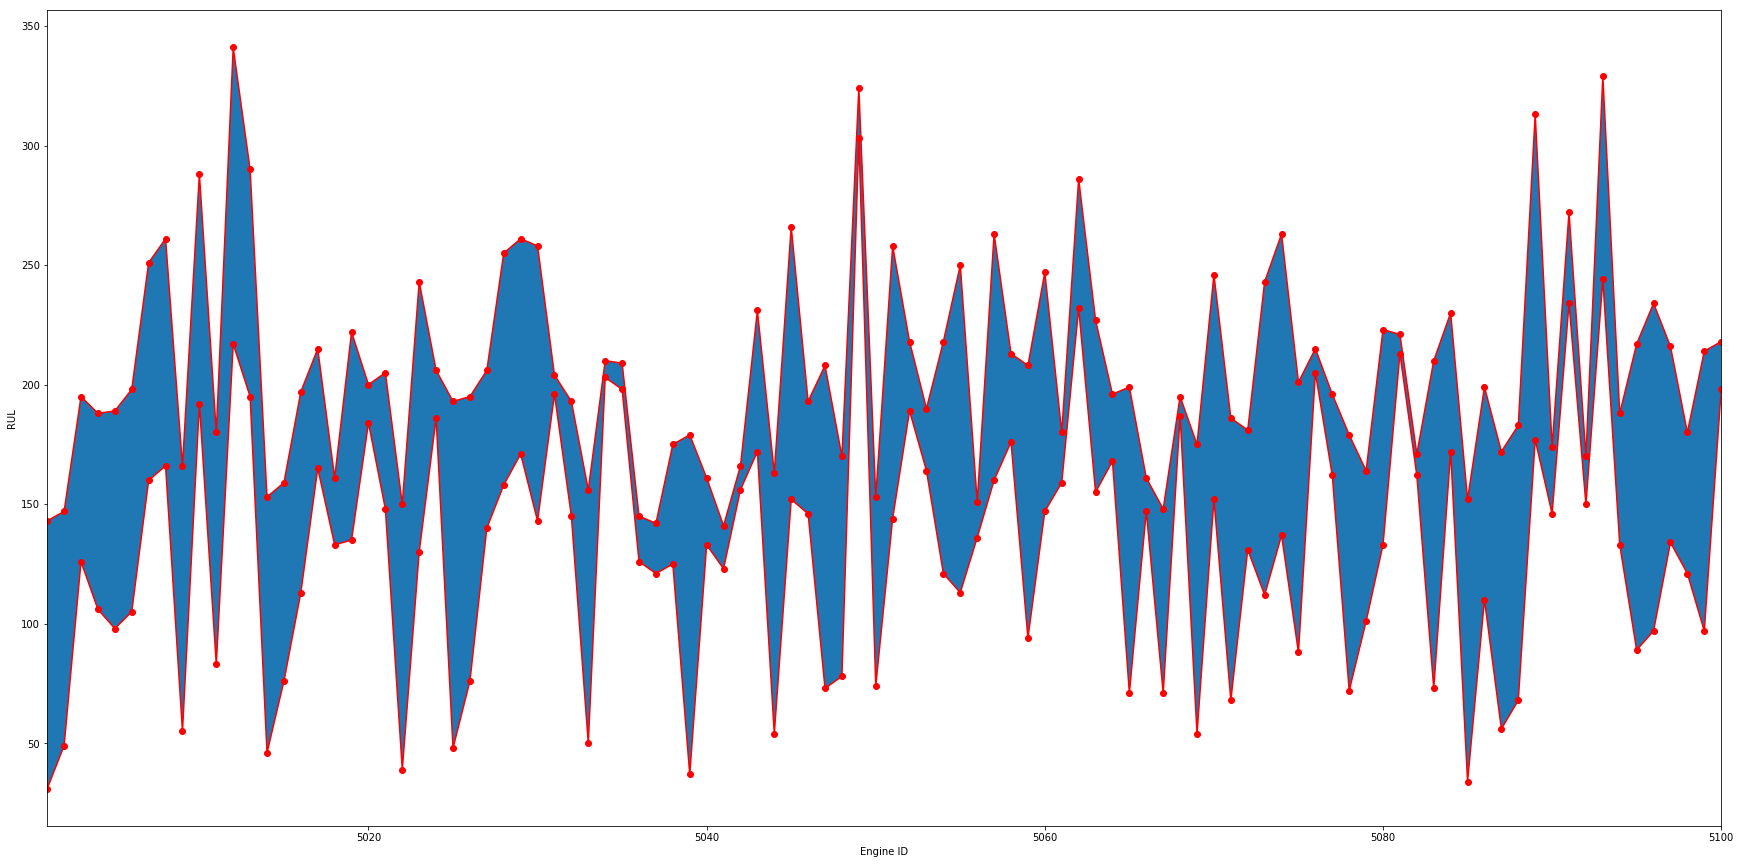

In [62]:
plt.figure( figsize=(30,15))
plt.plot(val_rul_df['id'], val_rul_df['RUL_actual'], 'ro-')
plt.plot(val_rul_df['id'], val_rul_df['cycles'], 'ro-')
plt.fill_between(val_rul_df['id'], val_rul_df['cycles'], val_rul_df['RUL_actual'])

plt.xlim(5001, 5100)
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.show()

Sample validation data to show the early stopping before the actual end of life. EOL is calculated by summing the number of cycles with the RUL ground truth. The sample below if before any degradation.

Engine: 5001, Samples: 31, Features: 3


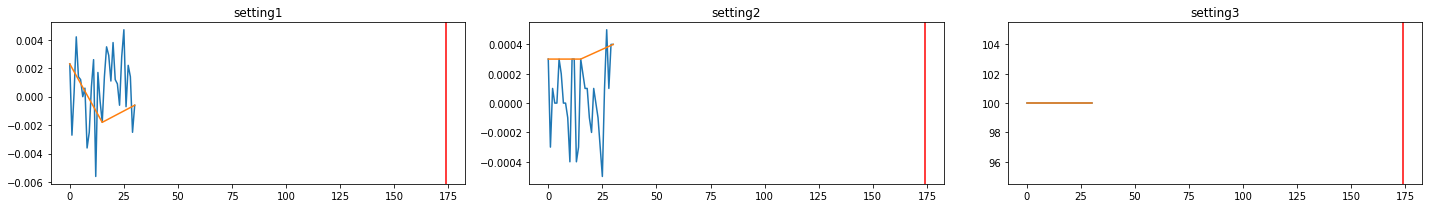

In [63]:
display_data(val_df, 5001, setting_cols, rul_df=val_rul_df, bspline=False)

Engine: 5001, Samples: 31, Features: 21


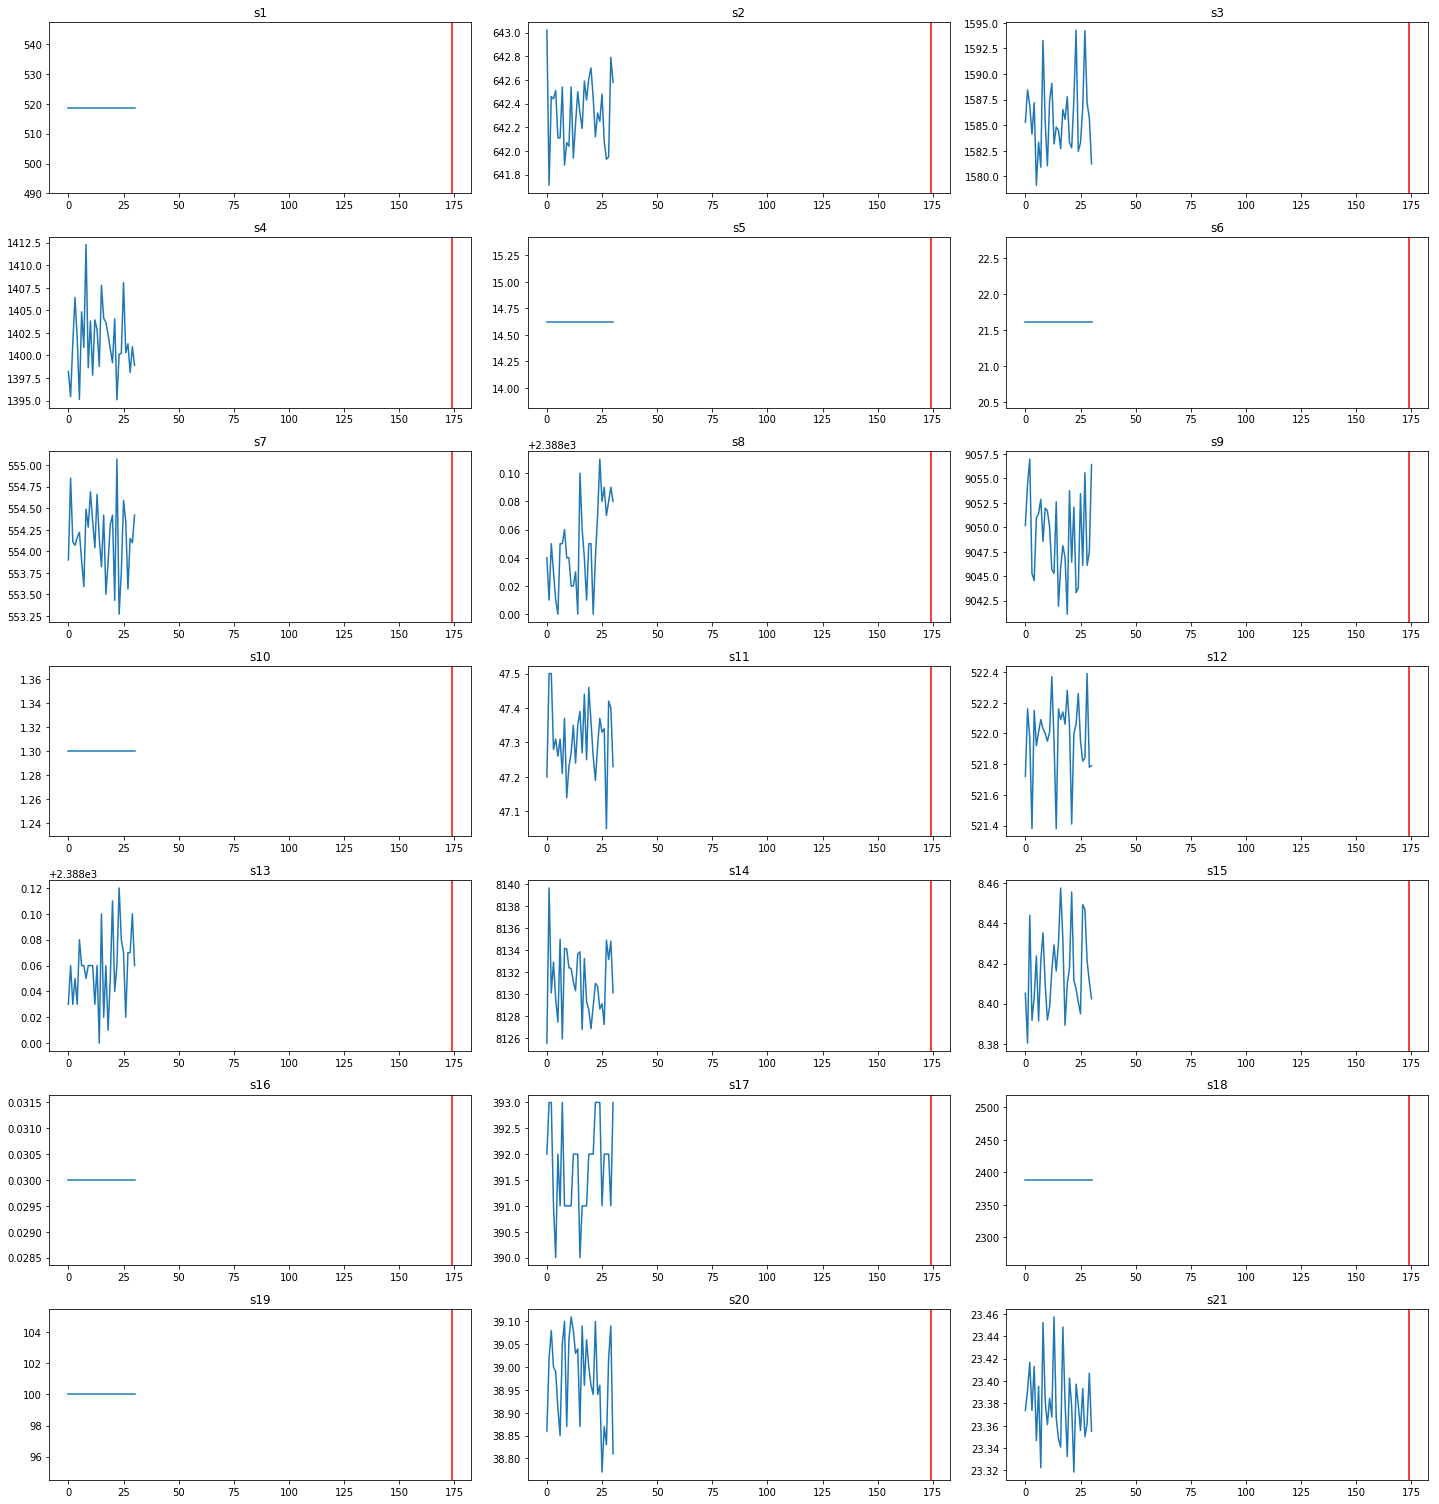

In [66]:
display_data(val_df, 5001, sensor_cols, rul_df=val_rul_df, bspline=False)